Цель: как можно раньше предсказать, что пользователь уйдет с курса.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(9,6)})

//Данные представлены за 3 года

event_data_train.csv - события происходящие на курсе 

submissions_data_train.csv - попытки сдачи тасков(каждого юзера) 

In [3]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head(8)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632


In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head(8)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853
7,31977,1434347371,correct,15853


ПРЕДОБРАБОТКА И АНАЛИТИКА ДАННЫХ

In [5]:
#Перевод timestamp(events_data) в удобный формат
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head(1)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15


In [6]:
#Перевод timestamp(submissions_data) в удобный формат
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp,unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head(1)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15


<AxesSubplot:xlabel='day'>

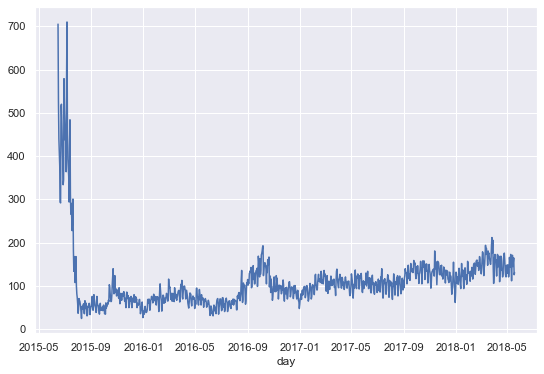

In [7]:
#Количество юзеров по дням
events_data.groupby('day').user_id.nunique().plot()

Выясним, сколько пользователей просматривало задания. 
Стоит учесть, что бывают пользователи которые не решали ни одного задания.(discovered)

<AxesSubplot:>

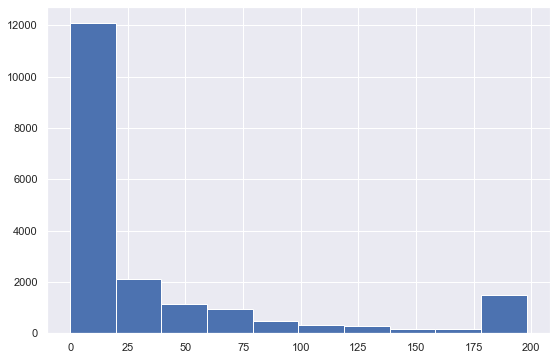

In [8]:
users_event = events_data.pivot_table(index='user_id',
                        columns='action',
                        values = 'step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_event.discovered.hist()

array([[<AxesSubplot:title={'center':'correct'}>,
        <AxesSubplot:title={'center':'wrong'}>]], dtype=object)

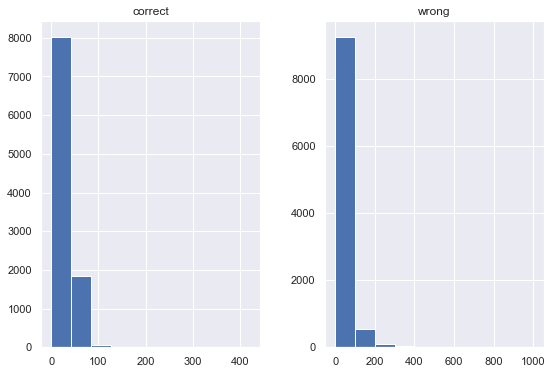

In [9]:
users_score = submissions_data.pivot_table(index='user_id',
                             columns = 'submission_status',
                             values = 'step_id',
                             aggfunc='count',
                             fill_value=0).reset_index()
users_score.hist(['correct','wrong'])

Определим пользователей которые бросили курс.
Важно! разделить пользователей на тех кто в процессе прохождения курса, и кто покинул курс. 

In [10]:
#определим временной порог, после которого можно считать, что пользователь покинул курс
#
#Уберём повторения по 'user_id','day', что бы определить уникальные дни
no_duplicates = events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])

#Соберём все уникальные дни для каждого пользователя и определим сколько времни прошло между днями активности
gap_data = no_duplicates.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data,axis = 0))

#Посчитаем разницу в днях
gap_data = gap_data / (24*60*60)

<AxesSubplot:>

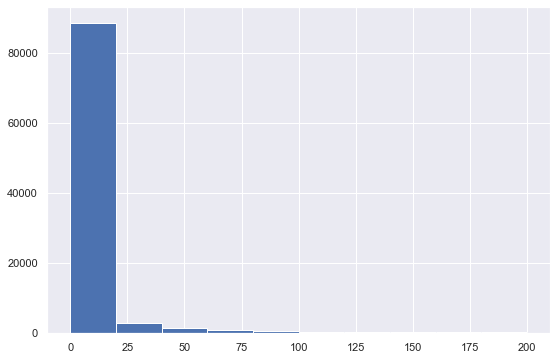

In [11]:
gap_data[gap_data < 200].hist()

In [12]:
print(f'Только 5% пользователей возвращается после перерыва {round(gap_data.quantile(0.95))} дней,'
      f'Только 10% пользователей возвращается после перерыва {round(gap_data.quantile(0.90))} дней')

Только 5% пользователей возвращается после перерыва 60 дней,Только 10% пользователей возвращается после перерыва 18 дней


Будем считать, что пользавтель покинул курс: ЕСЛИ (30 дней отсутсвовал на курсе И отсутствует сертификата об окончании)

In [13]:
#Определим пользователей покинувших курс
events_data.tail(3)

,step_id,timestamp,action,user_id,date,day
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [14]:
drop_out_tm = 30 * 24 * 60 * 60
now_tm = 1526772750

In [15]:
#определяем, кто не появлялся дольше 30 дней
users_data = events_data.groupby('user_id',as_index=False).agg({'timestamp':'max'})\
                        .rename(columns={'timestamp':'timestamp_max'})

users_data['is_going'] = (now_tm - users_data.timestamp_max) > drop_out_tm
users_data.head(2)

,user_id,timestamp_max,is_going
0,1,1472827464,True
1,2,1519226966,True


In [16]:
#определяем, кто получил/не получил сертификат

#Соберём вместе данные юзера(users_data) и его прогресс(users_score)
users_data = users_data.merge(users_score,on='user_id' ,how ='outer')
users_data = users_data.fillna(0)

#Соберём вместе данные users_data и users_event
users_data = users_data.merge(users_event, on = 'user_id', how ='outer')


In [17]:
#Собираем для каждого пользователя уникальные дни и добавляем в общий ДФ(users_data)
users_day = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_day,on = 'user_id', how ='outer')

In [18]:
users_data = users_data.rename(columns={'day':'uni_day'})
#сертификат
users_data['pass_corse'] = users_data.passed > 170

users_data.head()

,user_id,timestamp_max,is_going,correct,wrong,discovered,passed,started_attempt,viewed,uni_day,pass_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [19]:
users_data.groupby('pass_corse').agg('count')

,user_id,timestamp_max,is_going,correct,wrong,discovered,passed,started_attempt,viewed,uni_day
pass_corse,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [20]:
print(f'Только {round(1425/17809 * 100)}% пользователей завершили курс')

Только 8% пользователей завершили курс


Утверждаем, что в течении 3 дней можно предсказть уйдет ли пользователь с курса.

In [21]:
users_data[users_data.pass_corse].uni_day.median()

20.0

Отберём все события которые происходили с пользователем в течении 3 дней 

In [22]:
#Первое активное действие пользователя на курсе 
users_min_time = events_data.groupby('user_id', as_index= False).agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'},axis=1)
users_data = users_data.merge(users_min_time, how='outer', on='user_id')

In [23]:
users_data.head(3)

,user_id,timestamp_max,is_going,correct,wrong,discovered,passed,started_attempt,viewed,uni_day,pass_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476


In [24]:
#отобрать данные 
event_data_train = pd.DataFrame()

In [25]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)
events_data.head(3)

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848


In [26]:
time_threshold = 3 * 24 * 60 * 60

In [27]:
#Максимальное значение времени, после которого данные не будут использоваться
users_min_time['user_learning_time_threshold'] = users_min_time.user_id.map(str) + '_' + (users_min_time.min_timestamp + time_threshold).map(str)

In [28]:
events_data = events_data.merge(users_min_time[['user_id','user_learning_time_threshold']],how='outer',on = 'user_id')

In [29]:
event_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [30]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(users_min_time[['user_id','user_learning_time_threshold']],how='outer',on = 'user_id')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

Соберём фичи

In [31]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id':'step_tried'})

In [32]:
X = X.merge(steps_tried, how ='outer', on = 'user_id')

In [33]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                             columns = 'submission_status',
                             values = 'step_id',
                             aggfunc='count',
                             fill_value=0).reset_index(),how='outer')

In [34]:
X['correct_ratio'] = X['correct'] / (X['correct']+X['wrong'])

In [35]:
X = X.merge(events_data.pivot_table(index='user_id',
                        columns='action',
                        values = 'step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()[['user_id', 'viewed']],how='outer')
X = X.fillna(0)

In [36]:
X = X.merge(users_data[['user_id','pass_corse','is_going']],how='outer')

In [37]:
X = X[~((X['is_going'] == False) & (X['pass_corse'] == False))]

СОЗДАДИМ И ОБУЧИМ МОДЕЛЬ


In [38]:
y = X.pass_corse.map(int)
X = X.drop(['pass_corse','is_going'],axis = 1)


In [39]:
X = X.set_index(X.user_id).drop('user_id',axis=1)

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [50]:
clf = RandomForestClassifier(random_state=0)

In [51]:
parameters = {'n_estimators': range(10,50,10), 
              'max_depth' : range(1,12,2),
              'min_samples_leaf':range(1,7),
              'min_samples_split':range(2,9,2)}

In [52]:
grid_search_cv = GridSearchCV(clf,parameters,cv=3)

In [53]:
grid_search_cv.fit(X,y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(1, 12, 2),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': range(10, 50, 10)})

In [57]:
best_clf = grid_search_cv.best_estimator_

In [58]:
best_clf.score(X,y)

0.9745343341673617

In [68]:
event_data_test = pd.read_csv('events_data_test.csv')
event_data_test['date'] = pd.to_datetime(event_data_test.timestamp,unit ='s')
event_data_test['day'] = event_data_test.date.dt.date
event_data_test.head(3)

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21


In [67]:
submissions_data_test = pd.read_csv('submission_data_test.csv')
submissions_data_test['date'] = pd.to_datetime(submissions_data_test.timestamp, unit = 's')
submissions_data_test['day'] = submissions_data_test.date.dt.date
submissions_data_test.head(3)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20


In [71]:
submissions_data_test.isnull().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
date                 0
day                  0
dtype: int64

In [72]:
X

,day,step_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,10
3,1.0,4.0,4.0,4.0,0.50,192
8,1.0,11.0,9.0,21.0,0.30,156
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,698
26788,0.0,0.0,0.0,0.0,0.00,1
